In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

def classify_by_quantiles(series, labels):
    N = len(labels)
    percentiles = [100 * k / N for k in range(1, N)]  # e.g., for 3 labels → [33.33, 66.66]
    cut_points = np.percentile(series, percentiles)
    bins = [-np.inf] + list(cut_points) + [np.inf]
    return pd.cut(series, bins=bins, labels=labels)

# Configuración general
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "text.usetex": False,              # Usa True si tienes LaTeX instalado
    "font.family": "serif",            # Usa tipografía tipo LaTeX
    "font.serif": ["Times New Roman"], # O usa "Computer Modern Roman", "Palatino", etc.
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "figure.figsize": (6, 2.5),        # En la misma línea
    "savefig.bbox": "tight"
})

# --- 1. Tamaño y resolución de figuras ---
plt.rcParams['figure.figsize'] = (6, 4)  # Tamaño base de figuras
plt.rcParams['figure.dpi'] = 300         # Alta resolución para publicaciones

# --- 2. Fuente tipo LaTeX ---
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# --- 3. Estilo elegante y minimalista ---
sns.set_theme(style="white", palette="viridis", font_scale=1.2)


# Dark green to black:
DG_to_Bl = sns.color_palette("dark:#5A9_r") #, as_cmap=True)
# Grey blue to bone:
GB_to_Bo = sns.color_palette("blend:#7AB,#EDA") #, as_cmap=True)


# Elegante y visible
sns.set_palette(DG_to_Bl)




# Alternativas:
# sns.set_palette("Set2")
# sns.set_palette("coolwarm")
# sns.set_palette("crest")  # para categorías suaves

In [4]:
# Configuración general
sns.set_theme(style="whitegrid", context="paper")
plt.rcParams.update({
    "text.usetex": False,              # Usa True si tienes LaTeX instalado
    "font.family": "serif",            # Usa tipografía tipo LaTeX
    "font.serif": ["Times New Roman"], # O usa "Computer Modern Roman", "Palatino", etc.
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 8,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 150,
    "figure.figsize": (6, 2.5),        # En la misma línea
    "savefig.bbox": "tight"
})

In [11]:

# Load dataset
#df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results-two-bounds-lhs-1000.csv")  # Update with the actual filename
df = pd.read_csv("D:\\UBERMAG_RESULTS\\spin_wave_results_LHS_1000_LG2um.csv")  # Update with the actual filename 

# Check basic stats
print(df.info())
print(df.describe())


df = df[df["Transmission"] <= 0.99]
print(np.max(df["Transmission"]))
#df["Transmission"] = df["Transmission"] / np.max(df["Transmission"])


# TRANSFORM angle_u to sin(angle_u)

df["angle_theta"] = np.sin(df["angle_theta"] * np.pi / 180)
df.rename(columns={"angle_theta": "sin(U_theta)"}, inplace=True)

df["angle_phi"] = np.sin(df["angle_phi"] * np.pi / 180)
df.rename(columns={"angle_phi": "sin(U_phi)"}, inplace=True)

# Transform Phase Shift.


phases_rad = np.deg2rad(df["Phase Shift (deg)"])
mean_phase = np.angle(np.mean(np.exp(1j * phases_rad)))
centered_phases_rad = np.angle(np.exp(1j * (phases_rad - mean_phase)))
df["Phase Shift (deg)"] = np.rad2deg(centered_phases_rad) + 180


df["Transmission"] = np.log(df["Transmission"])
df.rename(columns={"Transmission": "log(T)"}, inplace=True)

df.rename(columns={"Phase Shift (deg)": r"$\Delta \phi$"}, inplace=True)
df.rename(columns={"M_s": r"$M_s$"}, inplace=True)
df.rename(columns={"alpha": r"$\alpha$"}, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   M_s                1000 non-null   float64
 1   A_ex               1000 non-null   float64
 2   K_u                1000 non-null   int64  
 3   alpha              1000 non-null   float64
 4   angle_theta        1000 non-null   float64
 5   angle_phi          1000 non-null   float64
 6   Transmission       1000 non-null   float64
 7   Phase Shift (deg)  1000 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 62.6 KB
None
                 M_s          A_ex     K_u        alpha  angle_theta  \
count    1000.000000  1.000000e+03  1000.0  1000.000000  1000.000000   
mean    72646.444567  4.000000e-12     0.0     0.015490    45.009230   
std     28001.224414  8.081978e-28     0.0     0.003178    26.008575   
min     24250.156001  4.000000e-12     0.0     0.010000     0.010314   

Etiqueta
10%    124
20%    124
30%    124
40%    124
50%    124
60%    124
70%    124
80%    124
Name: count, dtype: int64


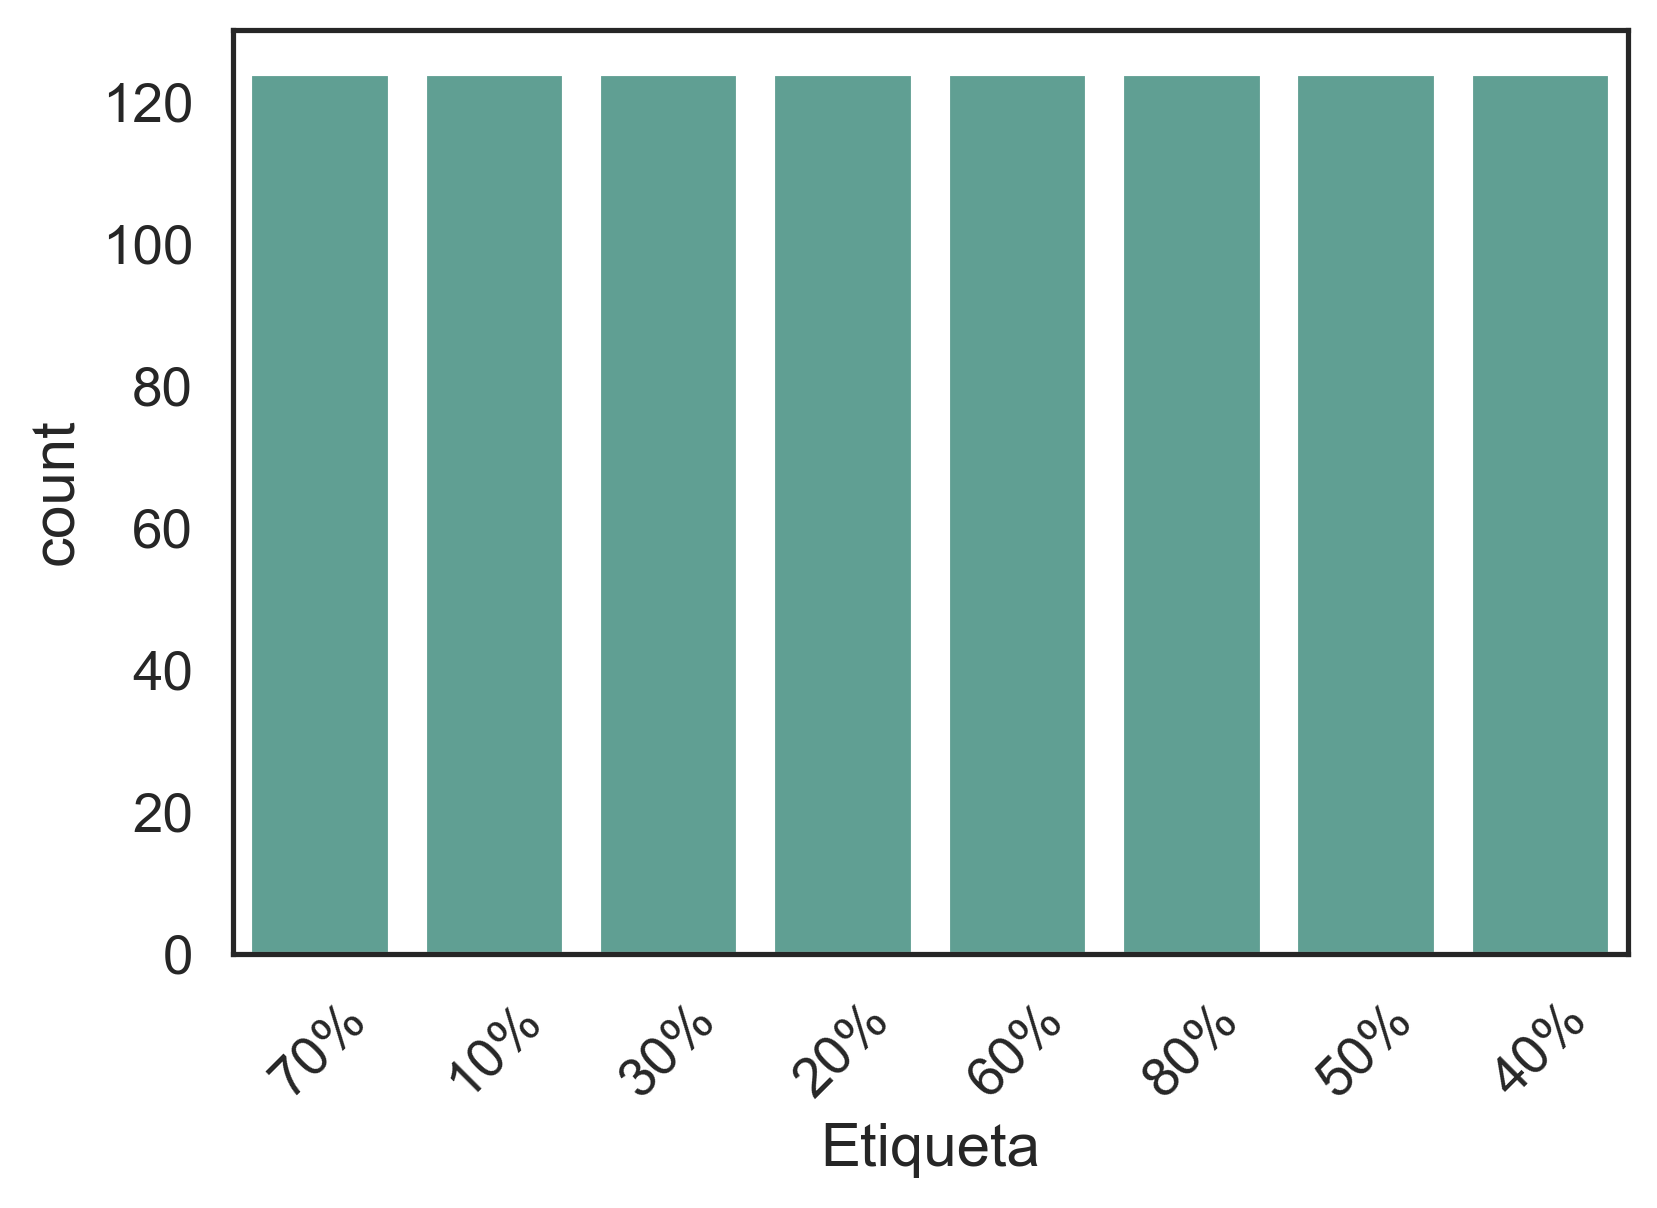

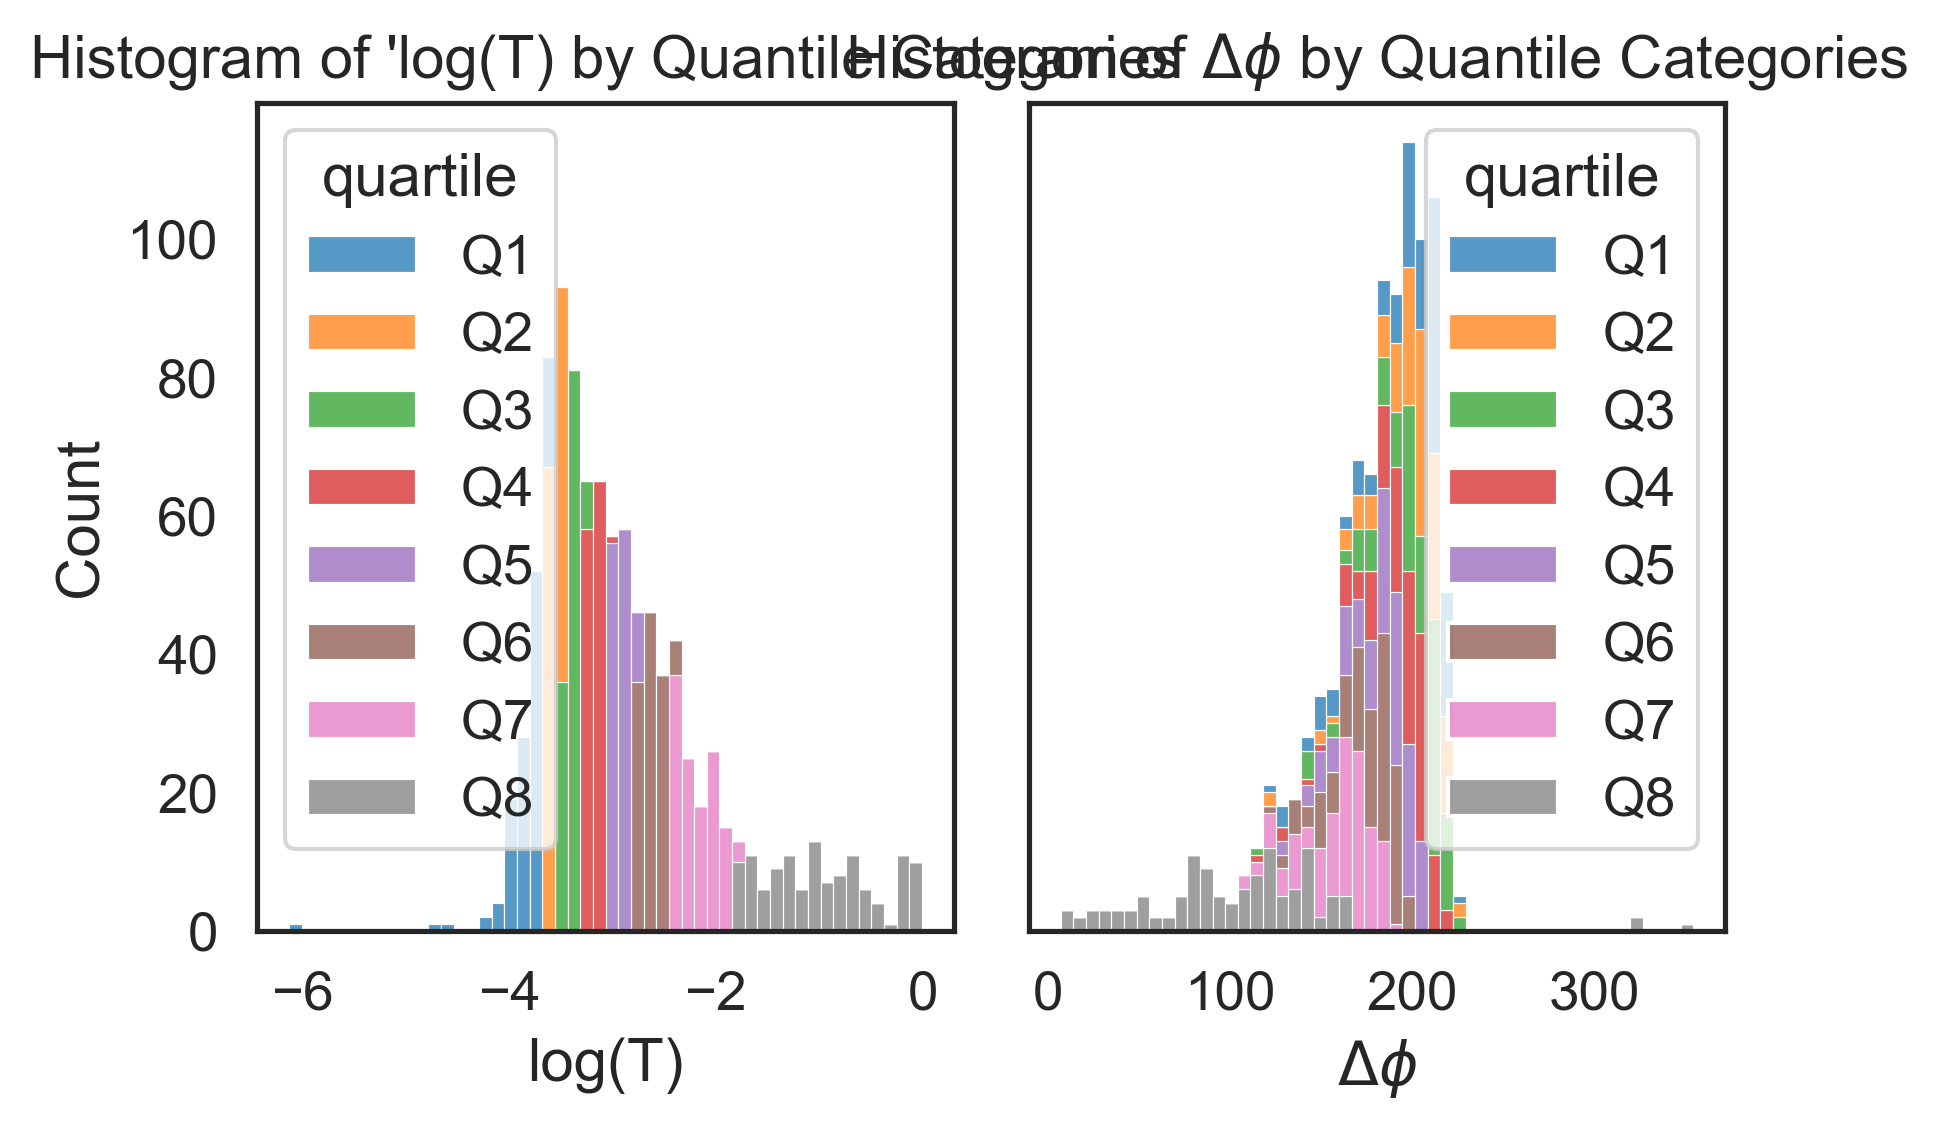

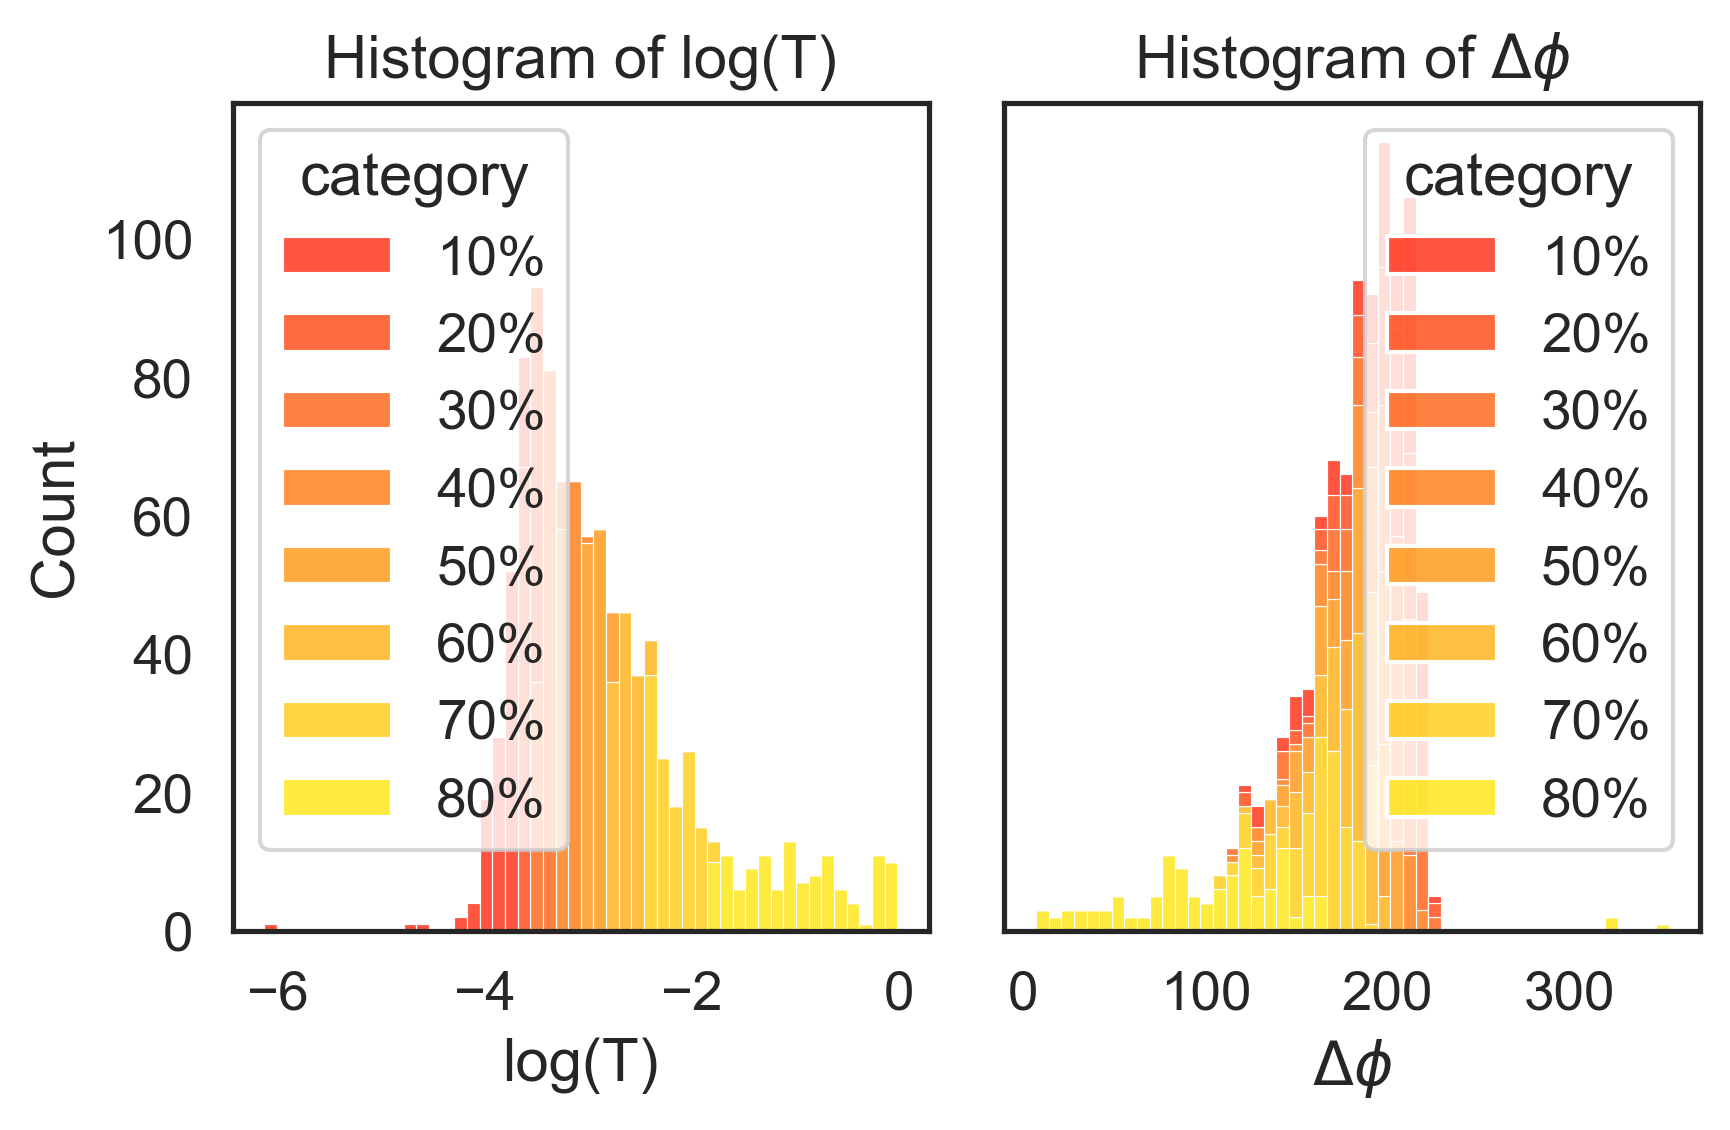

In [25]:

labels = ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%"]  # labels = ['Low', 'Medium', 'High']

# --- Clasificación por cuantiles ---
df['Transmision_cat'] = classify_by_quantiles(df['log(T)'], labels=labels)
df['Phase_cat'] = classify_by_quantiles(df[r"$\Delta \phi$"], labels=labels)

# --- Etiqueta combinada de clasificación multiclase ---
df['Etiqueta'] = df['Transmision_cat'].astype(str)# + '_' + df['Phase_cat'].astype(str)
df['Etiqueta_id'] = df['Etiqueta'].astype('category').cat.codes

# --- Comprobación del número de clases totales ---
class_counts = df['Etiqueta'].value_counts().sort_index()
print(class_counts)
sns.countplot(x='Etiqueta', data=df)
plt.xticks(rotation=45)

# --- See the quantiles in histograms ---
# Create 4 quantile-based categories (quartiles)
df['quartile'] = pd.qcut(df['log(T)'], q=8, labels=["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"])




fig, axes = plt.subplots(1, 2, sharey=True)
# Histograma de log(Transmission)
sns.histplot(
    data=df,
    x='log(T)',
    hue='quartile',
    bins=50,
    palette='tab10',
    multiple='stack',
    ax=axes[0]
)
#sns.kdeplot(data=df, x='log(Transmission)', hue='Etiqueta', fill=True, common_norm=False, alpha=0.5)
axes[0].set_title("Histogram of 'log(T) by Quantile Categories")
axes[0].set_xlabel("log(T)")
axes[0].set_ylabel("Count")

# Histograma de Phase Shift (deg)
sns.histplot(
    data=df,
    x=r"$\Delta \phi$",
    hue='quartile',
    bins=50,
    palette='tab10',
    multiple='stack',
    ax=axes[1]
)
#sns.kdeplot(data=df, x='log(Transmission)', hue='Etiqueta', fill=True, common_norm=False, alpha=0.5)
axes[1].set_title(r"Histogram of $\Delta \phi$ by Quantile Categories")
axes[1].set_xlabel(r"$\Delta \phi$")

# Mostrar leyenda solo una vez
handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Category', loc='upper center', ncol=len(labels))

plt.tight_layout()
plt.savefig("Histogram of Quantile.pdf", format='pdf')
plt.show()








# Define custom labels for quantile bins
labels = ["10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%"]  # labels = ['Low', 'Medium', 'High']
df['category'] = pd.qcut(df['log(T)'], q=8, labels=labels)


fig, axes = plt.subplots(1, 2, sharey=True)
# Histograma de log(Transmission)
sns.histplot(
    data=df,
    x='log(T)',
    hue='category',
    bins=50,
    palette='autumn',
    multiple='stack',
    ax=axes[0]
)
#sns.kdeplot(data=df, x='log(Transmission)', hue='Etiqueta', fill=True, common_norm=False, alpha=0.5)
axes[0].set_title("Histogram of log(T)")
axes[0].set_xlabel("log(T)")
axes[0].set_ylabel("Count")

# Histograma de Phase Shift (deg)
sns.histplot(
    data=df,
    x=r"$\Delta \phi$",
    hue='category',
    bins=50,
    palette='autumn',
    multiple='stack',
    ax=axes[1]
)
#sns.kdeplot(data=df, x='log(Transmission)', hue='Etiqueta', fill=True, common_norm=False, alpha=0.5)
axes[1].set_title(r"Histogram of $\Delta \phi$")
axes[1].set_xlabel(r"$\Delta \phi$")

# Mostrar leyenda solo una vez
handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, title='Category', loc='upper center', ncol=len(labels))

plt.tight_layout()
plt.savefig("Histogram of Category.pdf", format='pdf')
plt.show()


seed = 33

# --- Variables explicativas ---
X = df.drop(columns=['log(T)', r"$\Delta \phi$", 'Transmision_cat', 'Phase_cat', 'Etiqueta', 'Etiqueta_id', 'quartile', 'category'])
y_T = df['log(T)']
y_P = df[r"$\Delta \phi$"]

# --- Escalado y división en entrenamiento / prueba ---
X_train, X_test, y_T_train, y_T_test, y_P_train, y_P_test = train_test_split(X, y_T, y_P, test_size=0.2, random_state=seed, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Transmission (T)
Best params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Best MAE (CV): 0.13437925954839205

Phase Shift (Δφ)
Best params: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best MAE (CV): 5.266833020488918


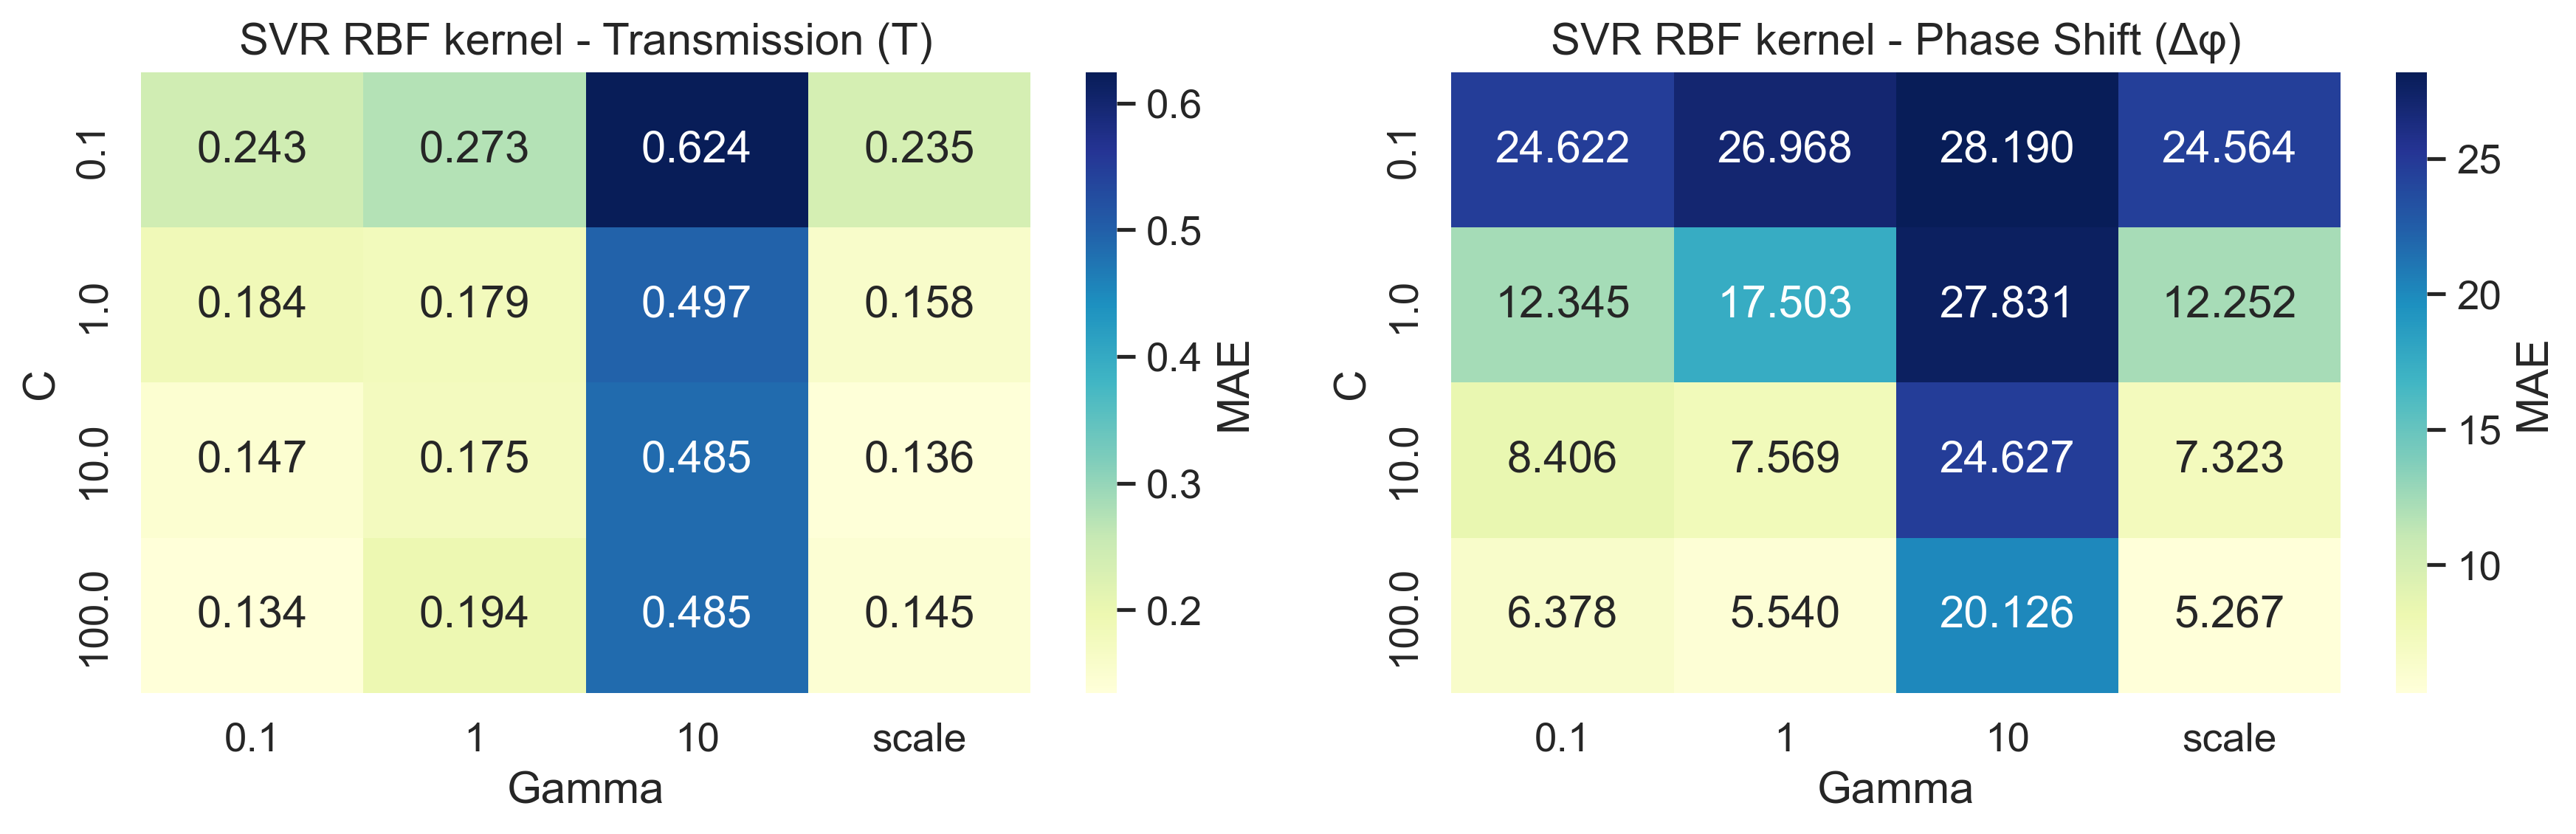

In [33]:
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.1, 1, 10]},
    {'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'gamma': ['scale', 0.1, 1]},
    {'kernel': ['sigmoid'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 0.1, 1]}
]
# ============================================================
# Train for both targets
# ============================================================
targets = {
    "Transmission (T)": (y_T_train, y_T_test),
    "Phase Shift (Δφ)": (y_P_train, y_P_test)
}

best_models = {}
heatmaps_data = {}
predictions = {}

for name, (y_train, y_test) in targets.items():
    grid = GridSearchCV(
        SVR(),
        param_grid,
        cv=5,
        scoring='neg_mean_absolute_error',
        verbose=0,
        n_jobs=-1
    )
    grid.fit(X_train_scaled, y_train)

    best_models[name] = grid.best_estimator_
    print(f"\n{name}")
    print("Best params:", grid.best_params_)
    print("Best MAE (CV):", -grid.best_score_)

    # Filter RBF results for heatmap
    results_df = pd.DataFrame(grid.cv_results_)
    results_df['mean_MAE'] = -results_df['mean_test_score']
    rbf_results = results_df[results_df['param_kernel'] == 'rbf']

    pivot_table = rbf_results.pivot_table(
        values='mean_MAE',
        index='param_C',
        columns='param_gamma'
    )
    heatmaps_data[name] = pivot_table

    # Store predictions
    y_pred = best_models[name].predict(X_test_scaled)
    predictions[name] = (y_test, y_pred)

# ============================================================
# Plot side-by-side heatmaps
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (name, pivot_table) in zip(axes, heatmaps_data.items()):
    sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu",
                cbar_kws={'label': 'MAE'}, ax=ax)
    ax.set_title(f"SVR RBF kernel - {name}")
    ax.set_xlabel("Gamma")
    ax.set_ylabel("C")

plt.tight_layout()
plt.savefig("svr_grid_search.pdf", format='pdf')
plt.show()


In [28]:

svr_T = best_models["Transmission (T)"]
svr_P = best_models["Phase Shift (Δφ)"]


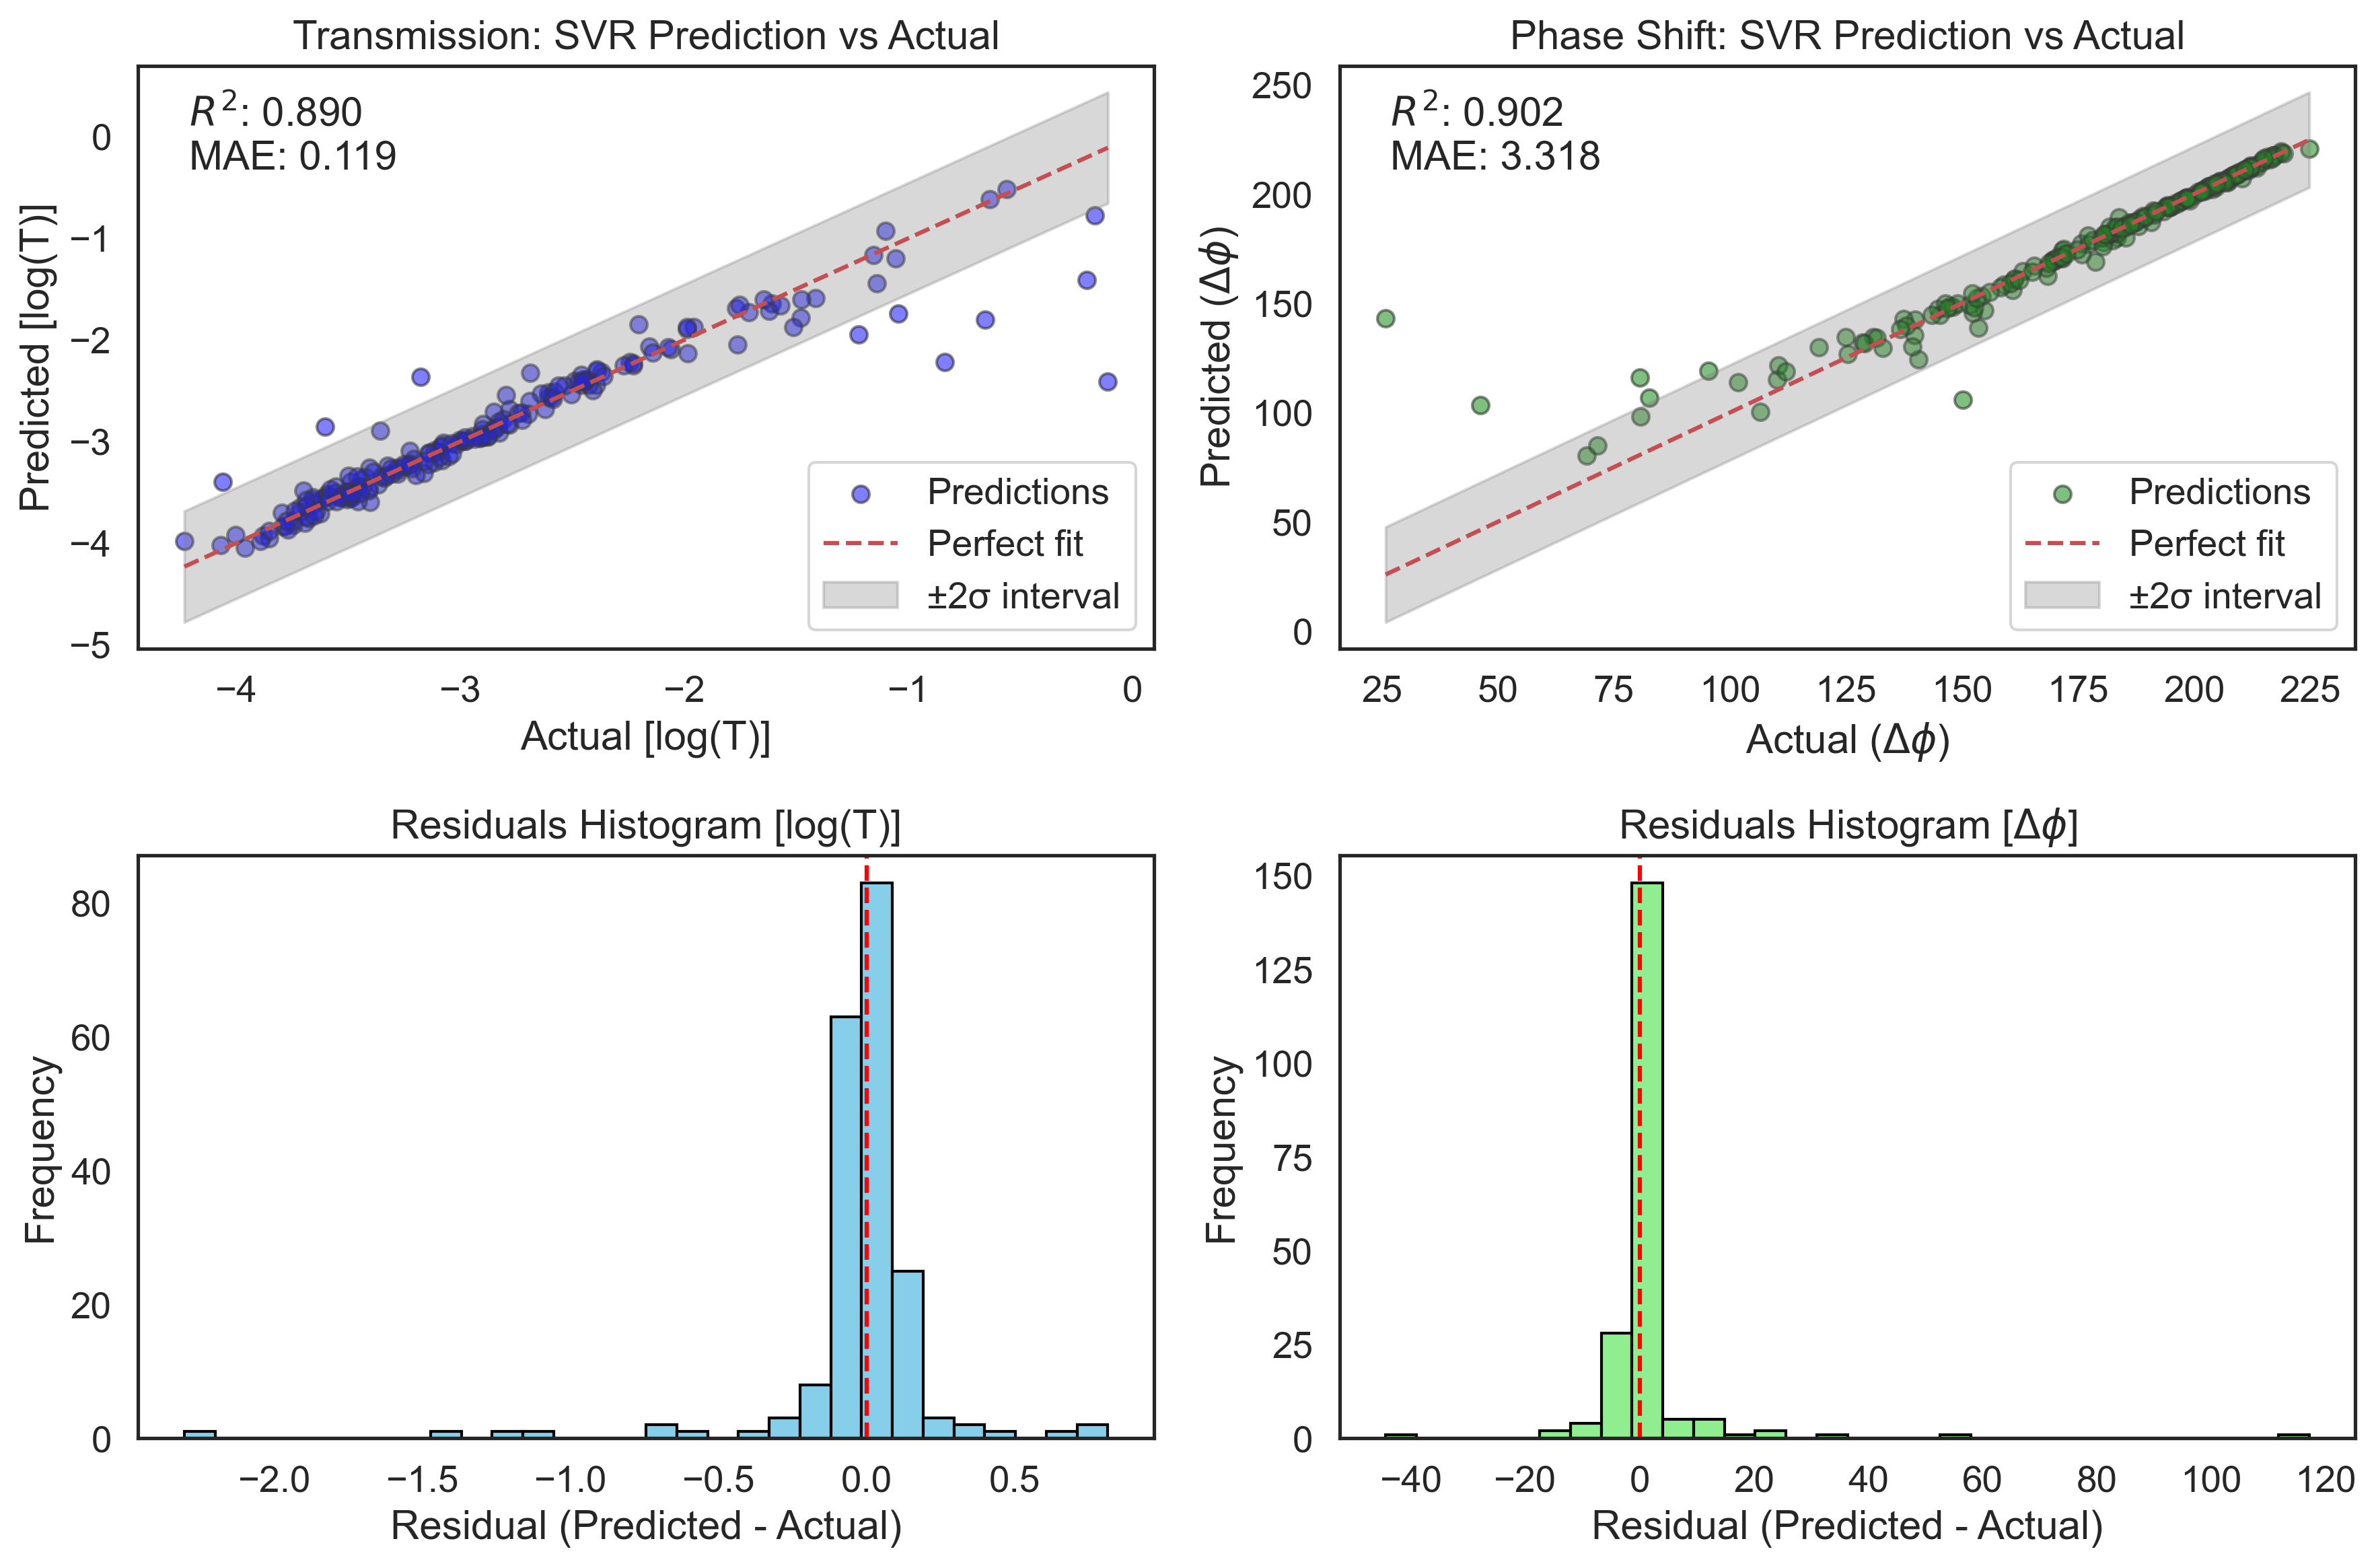

In [27]:
from sklearn.metrics import mean_absolute_error

# predictions dict = {"name": (y_test, y_pred)}
# This comes from your SVR loop earlier

# --- Compute residuals, std, metrics ---
(y_test_T, y_pred_T) = predictions["Transmission (T)"]
(y_test_P, y_pred_P) = predictions["Phase Shift (Δφ)"]

residuals_T = y_pred_T - y_test_T
residuals_P = y_pred_P - y_test_P

std_T = np.std(residuals_T)
std_P = np.std(residuals_P)

r2_T = r2_score(y_test_T, y_pred_T)
mae_T = mean_absolute_error(y_test_T, y_pred_T)

r2_P = r2_score(y_test_P, y_pred_P)
mae_P = mean_absolute_error(y_test_P, y_pred_P)

# --- Create figure ---
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# === Plot 1a: Scatter + PI for Transmission ===
axs[0, 0].scatter(y_test_T, y_pred_T, alpha=0.5, edgecolor='k', color='blue', label="Predictions")
line_T = np.linspace(min(y_test_T), max(y_test_T), 100)
axs[0, 0].plot(line_T, line_T, 'r--', label="Perfect fit")
axs[0, 0].fill_between(line_T, line_T - 2*std_T, line_T + 2*std_T, color='gray', alpha=0.3, label="±2σ interval")

axs[0, 0].set_title("Transmission: SVR Prediction vs Actual")
axs[0, 0].set_xlabel("Actual [log(T)]")
axs[0, 0].set_ylabel("Predicted [log(T)]")
axs[0, 0].legend()
axs[0, 0].text(
    0.05, 0.95,
    f"$R^2$: {r2_T:.3f}\nMAE: {mae_T:.3f}",
    transform=axs[0, 0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 1b: Residuals Histogram for Transmission ===
axs[1, 0].hist(residuals_T, bins=30, color='skyblue', edgecolor='black')
axs[1, 0].axvline(0, color='red', linestyle='--')
axs[1, 0].set_title("Residuals Histogram [log(T)]")
axs[1, 0].set_xlabel("Residual (Predicted - Actual)")
axs[1, 0].set_ylabel("Frequency")

# === Plot 2a: Scatter + PI for Phase Shift ===
axs[0, 1].scatter(y_test_P, y_pred_P, alpha=0.5, edgecolor='k', color='green', label="Predictions")
line_P = np.linspace(min(y_test_P), max(y_test_P), 100)
axs[0, 1].plot(line_P, line_P, 'r--', label="Perfect fit")
axs[0, 1].fill_between(line_P, line_P - 2*std_P, line_P + 2*std_P, color='gray', alpha=0.3, label="±2σ interval")

axs[0, 1].set_title("Phase Shift: SVR Prediction vs Actual")
axs[0, 1].set_xlabel(r"Actual ($\Delta\phi$)")
axs[0, 1].set_ylabel(r"Predicted ($\Delta\phi$)")
axs[0, 1].legend()
axs[0, 1].text(
    0.05, 0.95,
    f"$R^2$: {r2_P:.3f}\nMAE: {mae_P:.3f}",
    transform=axs[0, 1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
)

# === Plot 2b: Residuals Histogram for Phase Shift ===
axs[1, 1].hist(residuals_P, bins=30, color='lightgreen', edgecolor='black')
axs[1, 1].axvline(0, color='red', linestyle='--')
axs[1, 1].set_title(r"Residuals Histogram [$\Delta\phi$]")
axs[1, 1].set_xlabel("Residual (Predicted - Actual)")
axs[1, 1].set_ylabel("Frequency")

# --- Layout and Save ---
plt.tight_layout()
plt.savefig("svr_scatter_residuals.pdf", format='pdf')
plt.show()


In [31]:
def svr_to_latex(svr):
    b = svr.intercept_[0]
    gamma = svr._gamma
    terms = []
    for coef, sv in zip(svr.dual_coef_[0], svr.support_vectors_):
        sv_str = " + ".join([f"(x_{j} - {v:.3f})^2" for j, v in enumerate(sv, 1)])
        terms.append(f"{coef:.3f} \\cdot e^{{-{gamma:.3f}({sv_str})}}")
    expr = "y(x) = " + " + ".join(terms) + f" + {b:.3f}"
    return expr

latex_expr_T = svr_to_latex(svr_T)
#print(latex_expr_T)
latex_expr_P = svr_to_latex(svr_P)
#print(latex_expr_P)

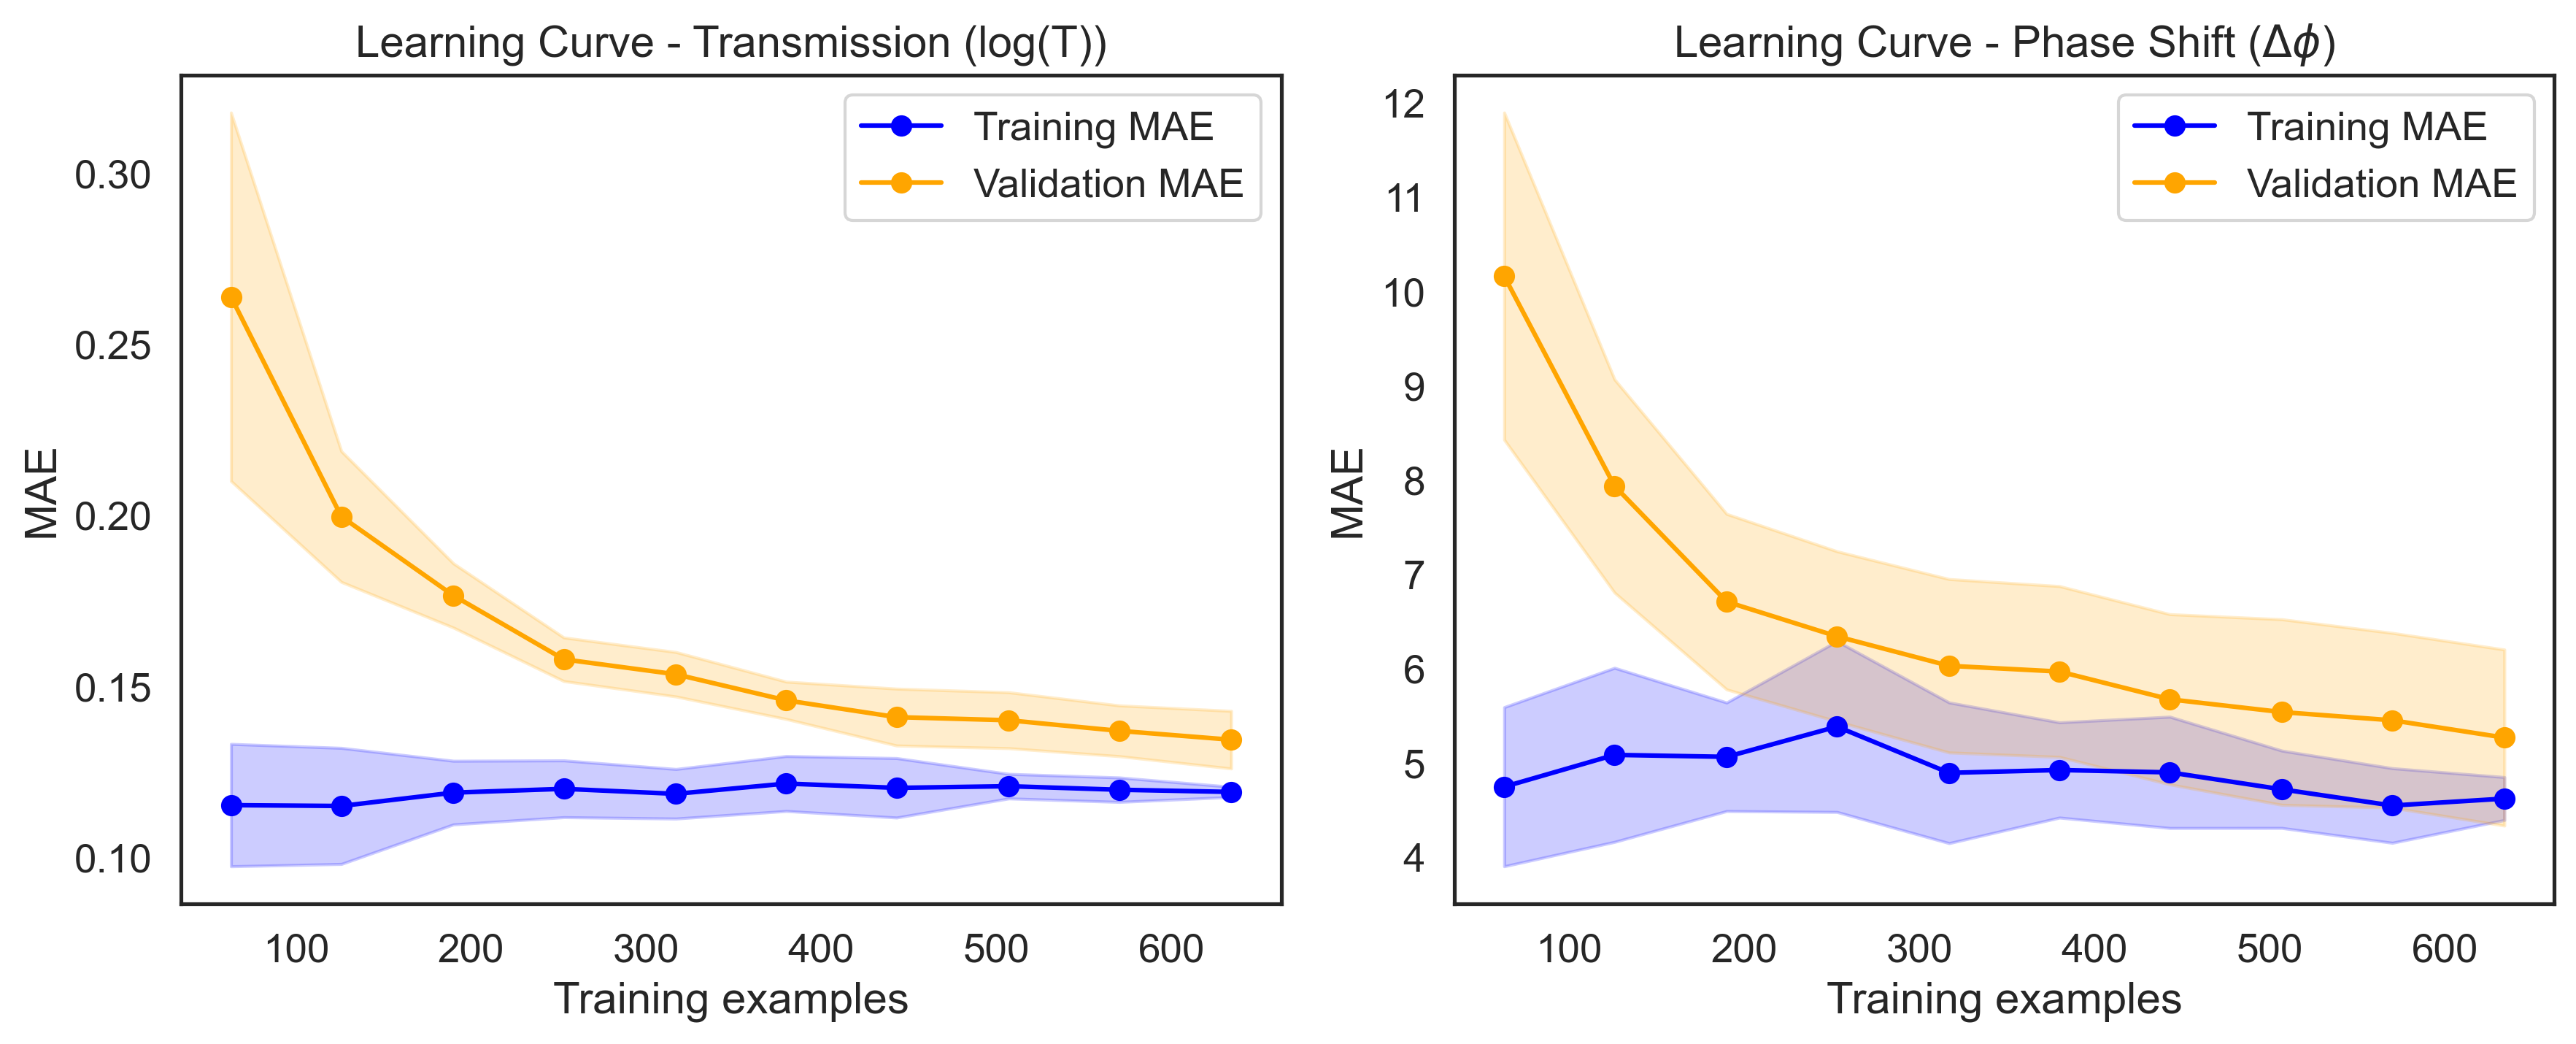

In [32]:

# --- Helper function ---
def plot_learning_curve(estimator, X, y, ax, title):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring='neg_mean_absolute_error',
        train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1, shuffle=True, random_state=42
    )

    # Convert negative MAE to positive
    train_scores = -train_scores
    val_scores = -val_scores

    # Mean and std
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot
    ax.plot(train_sizes, train_mean, 'o-', label="Training MAE", color='blue')
    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

    ax.plot(train_sizes, val_mean, 'o-', label="Validation MAE", color='orange')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MAE")
    ax.grid(False)
    ax.legend()

# === Plot side by side ===
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_learning_curve(svr_T, X_train_scaled, y_T_train, axs[0], "Learning Curve - Transmission (log(T))")
plot_learning_curve(svr_P, X_train_scaled, y_P_train, axs[1], r"Learning Curve - Phase Shift ($\Delta \phi$)")

plt.tight_layout()
plt.savefig("learning_curves_SVR.pdf", format='pdf')
plt.show()


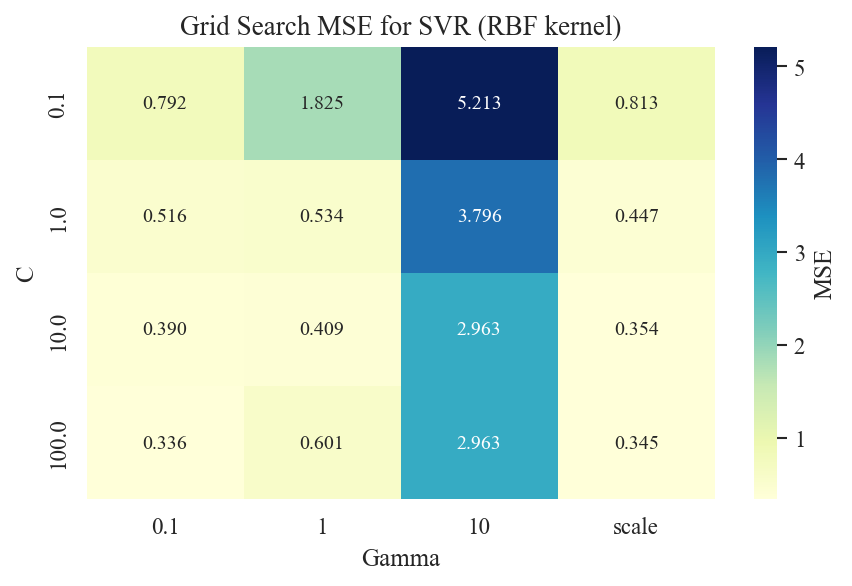

In [15]:
# Convert results to DataFrame
results_df = pd.DataFrame(grid.cv_results_)

# Add a column with positive MSE (since scoring='neg_mean_squared_error')
results_df['mean_MSE'] = -results_df['mean_test_score']

# Filter only RBF kernel
rbf_results = results_df[results_df['param_kernel'] == 'rbf']

# Pivot to get C on one axis, gamma on the other
pivot_table = rbf_results.pivot_table(
    values='mean_MSE',
    index='param_C',
    columns='param_gamma'
)

# Plot heatmap
plt.figure(figsize=(6,4))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", cbar_kws={'label': 'MSE'})
plt.title("Grid Search MSE for SVR (RBF kernel)")
plt.xlabel("Gamma")
plt.ylabel("C")
plt.tight_layout()
plt.show()

MSE en test: 0.3989
R² en test: 0.9239


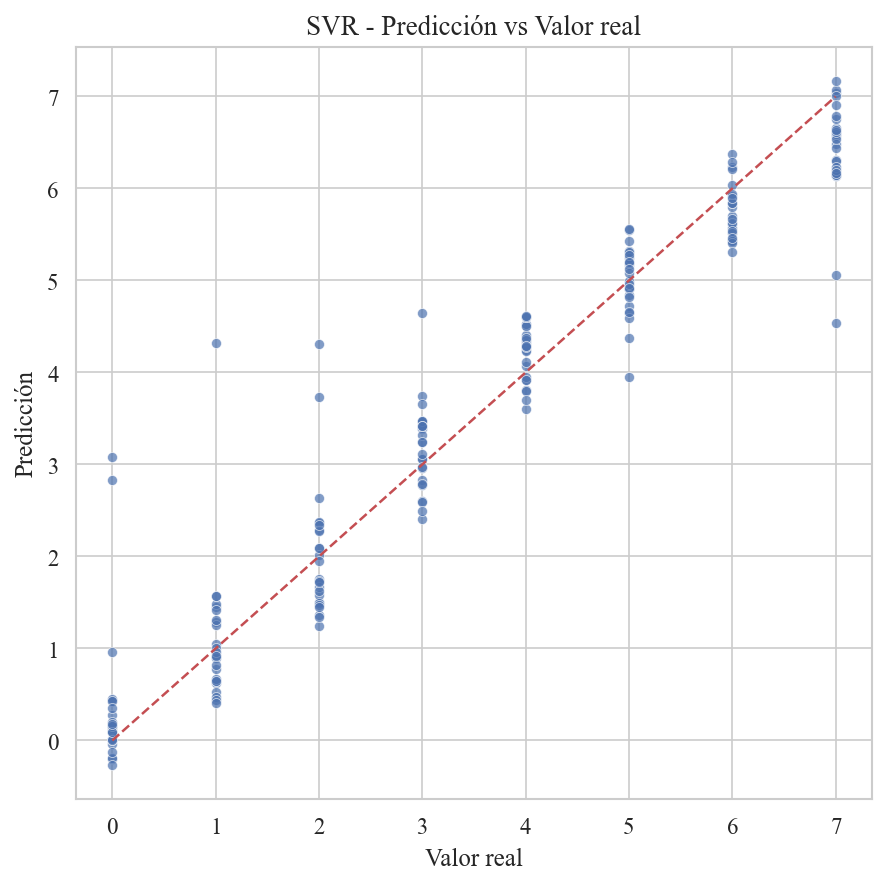

In [16]:

# --- Entrenamiento con mejores hiperparámetros ---
reg = SVR(kernel='rbf', C=10, gamma=0.1)
reg.fit(X_train_scaled, y_train)

# --- Predicción ---
y_pred = reg.predict(X_test_scaled)

# --- Evaluación ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE en test: {mse:.4f}")
print(f"R² en test: {r2:.4f}")

# --- Gráfico predicciones vs reales ---
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # línea ideal
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("SVR - Predicción vs Valor real")
plt.tight_layout()
plt.show()

In [81]:
train_score = clf.score(X_train_scaled, y_train)
test_score = clf.score(X_test_scaled, y_test)

print(f"Training accuracy: {train_score:.3f}")
print(f"Test accuracy: {test_score:.3f}")

Training accuracy: 0.891
Test accuracy: 0.700


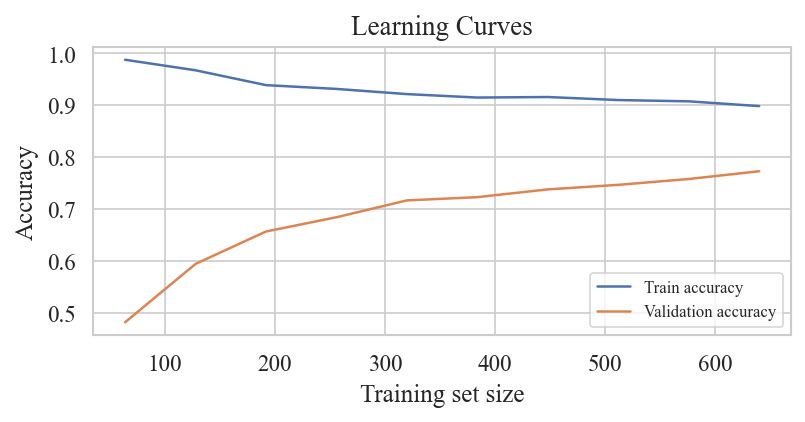

In [82]:
train_sizes, train_scores, val_scores = learning_curve(
    clf, X_train_scaled, y_train, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Train accuracy')
plt.plot(train_sizes, val_mean, label='Validation accuracy')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()

## VISUALIZACIÓN DE LAS CLASES Y LÍNEAS DE DIVISIÓN:

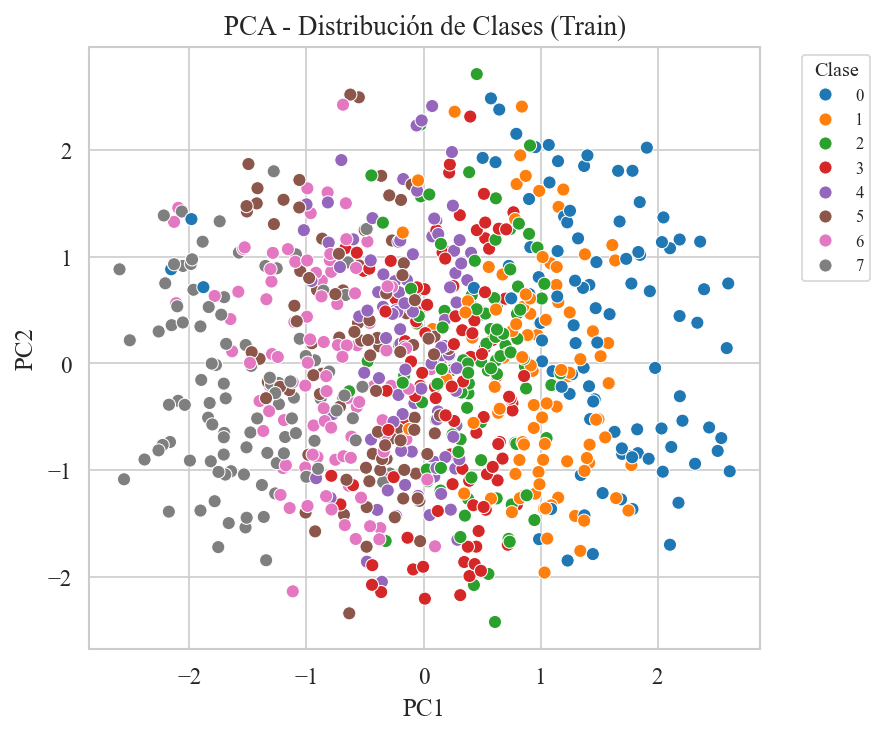

In [84]:

# Aplica PCA a tus datos escalados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Visualiza con las etiquetas verdaderas
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='tab10', s=40)
plt.title("PCA - Distribución de Clases (Train)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clase", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [85]:
# Get the first principal component (PC1)
pc1 = pca.components_[0]  # shape: (n_features,)

# Get feature names (from your training data)
feature_names = X_train.columns

# Create a DataFrame for PC1 formula
pc1_formula = pd.Series(pc1, index=feature_names)

# Print the formula in readable format
formula = "PC1 = " + " + ".join([f"{coef:.3f}*{name}" for name, coef in pc1_formula.items()])
print(formula)

PC1 = -0.501*M_s + 0.000*A_ex + -0.000*K_u + -0.117*alpha + -0.554*sin(U_theta) + 0.654*sin(U_phi)


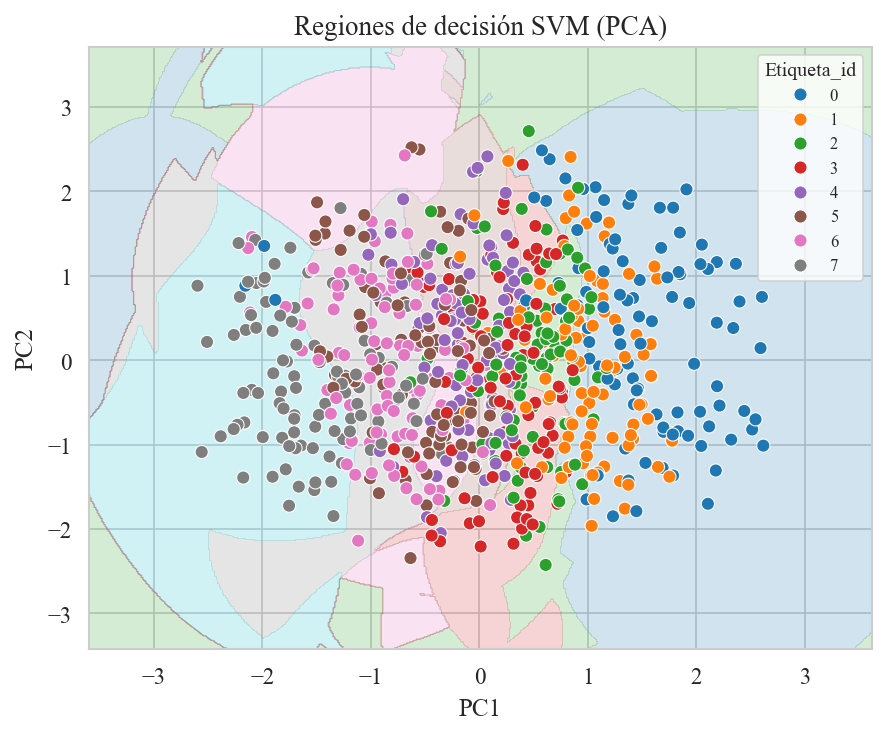

In [86]:
# Entrena el modelo en las 2 componentes principales
clf_2d = SVC(kernel='rbf', C=100, gamma='scale')
clf_2d.fit(X_pca, y_train)

# Malla para regiones de decisión
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Visualiza regiones de decisión
plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.2, cmap='tab10')
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='tab10', s=40)
plt.title("Regiones de decisión SVM (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

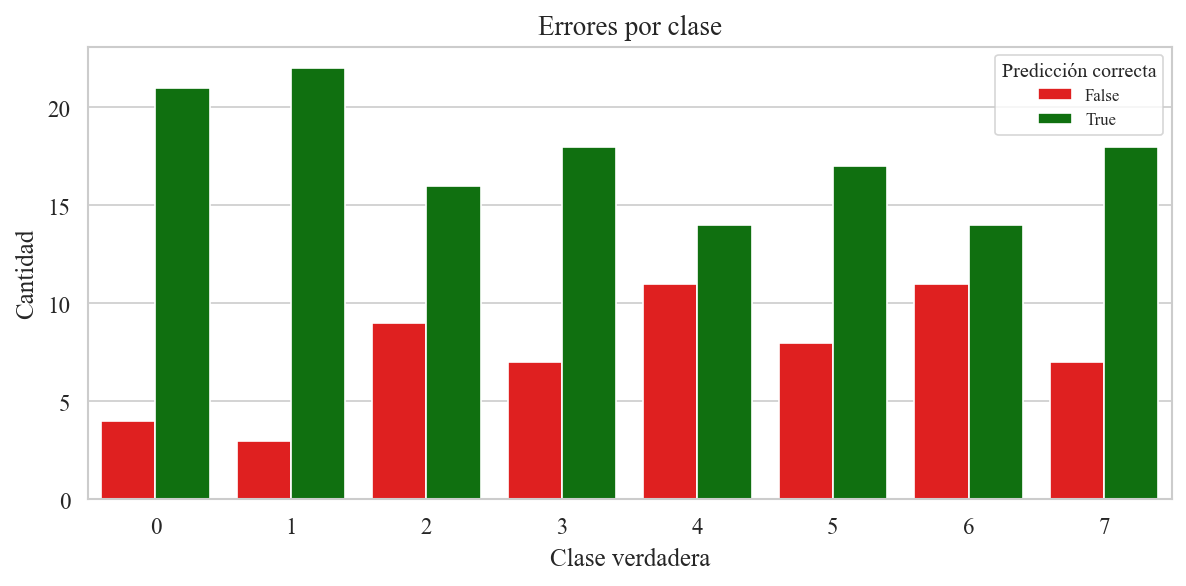

In [87]:
error_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
error_df['correcto'] = error_df['y_true'] == error_df['y_pred']

plt.figure(figsize=(8, 4))
sns.countplot(data=error_df, x='y_true', hue='correcto', palette={True: 'green', False: 'red'})
plt.title("Errores por clase")
plt.xlabel("Clase verdadera")
plt.ylabel("Cantidad")
plt.legend(title="Predicción correcta")
plt.tight_layout()
plt.show()